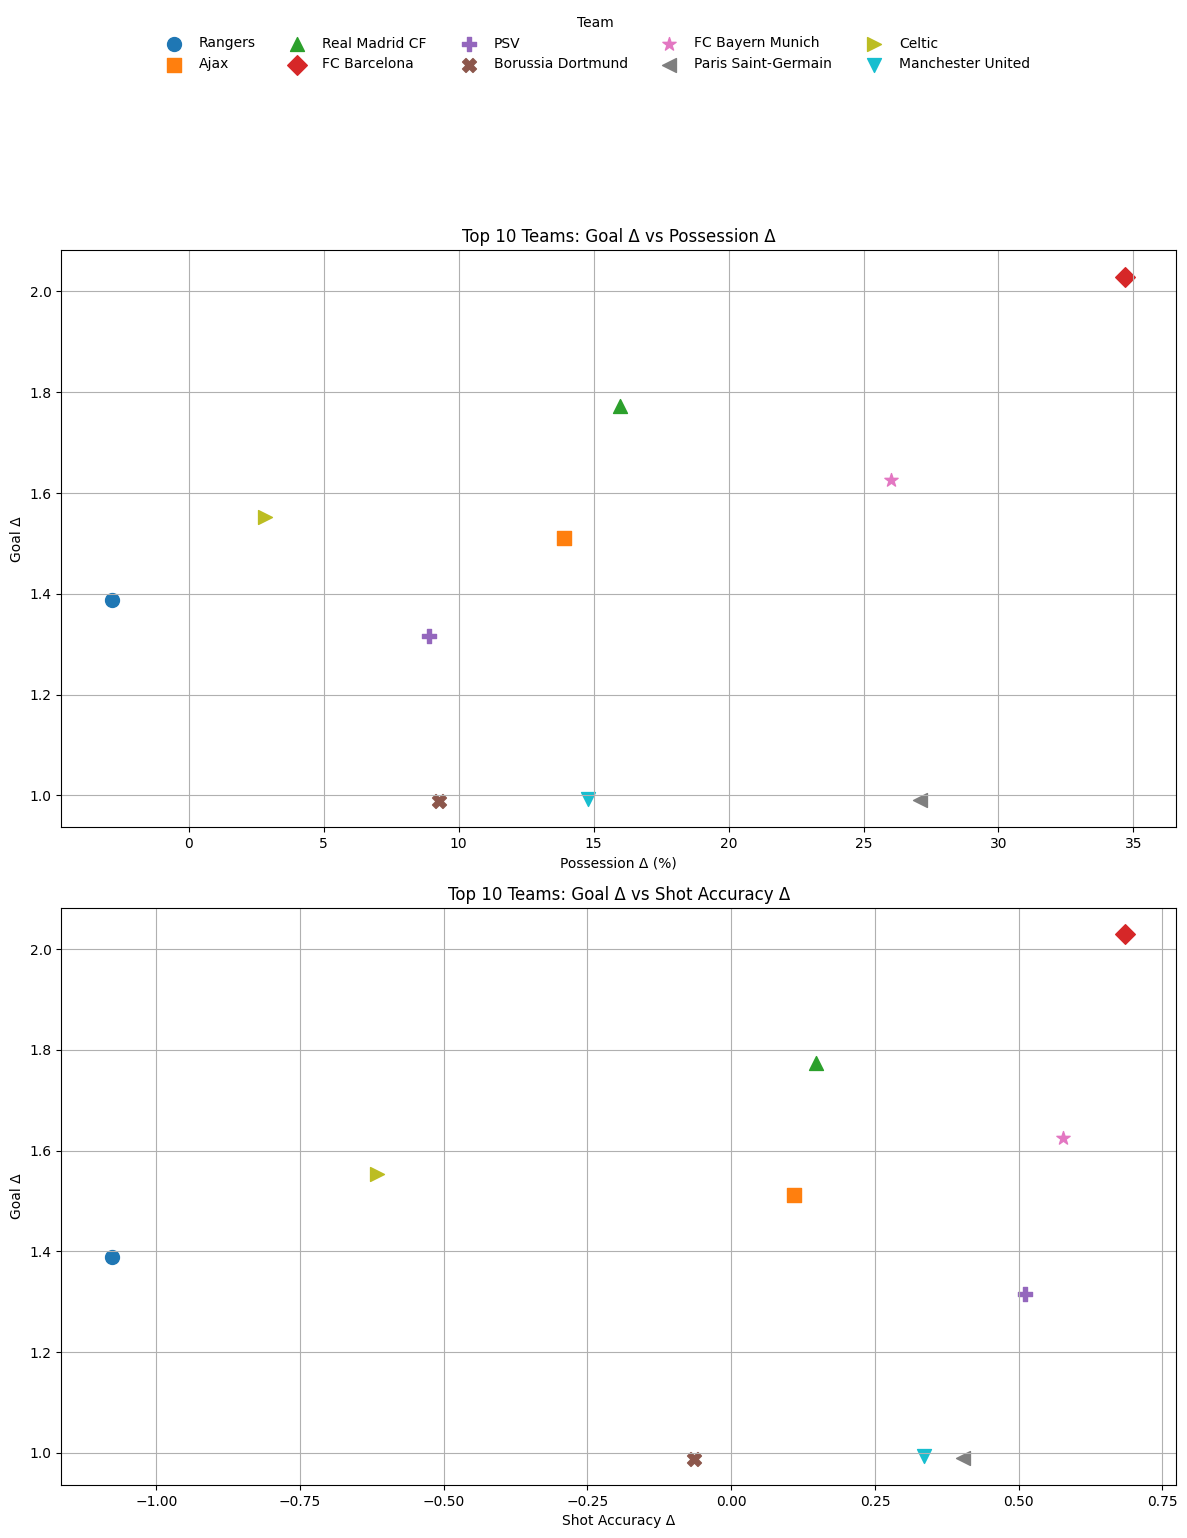

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# === 1. Load data ===
folder = r"C:/uhasselt/SecondSemester/VISUALIZATION/VDS2425 Football"

# Load files
match = pd.read_csv(os.path.join(folder, "Match.csv"))

# Possession file (handle typo)
poss_file = "Match_Possession.csv"
if not os.path.exists(os.path.join(folder, poss_file)):
    poss_file = "Match_Possesion.csv"
possession = pd.read_csv(os.path.join(folder, poss_file))

shots_on = pd.read_csv(os.path.join(folder, "Match_Shots_On.csv"))
shots_off = pd.read_csv(os.path.join(folder, "Match_Shots_Off.csv"))
teams = pd.read_csv(os.path.join(folder, "Team.csv"))

# === 2. Compute Goal Δ ===
goal_df_home = match[['id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].copy()
goal_df_home = goal_df_home.rename(columns={'id': 'match_id'})
goal_df_home['Goal_Diff'] = goal_df_home['home_team_goal'] - goal_df_home['away_team_goal']

goal_home = goal_df_home[['match_id', 'home_team_api_id', 'Goal_Diff']].rename(columns={'home_team_api_id': 'team_api_id'})
goal_away = goal_df_home[['match_id', 'away_team_api_id', 'Goal_Diff']].copy()
goal_away['Goal_Diff'] = -goal_away['Goal_Diff']
goal_away = goal_away.rename(columns={'away_team_api_id': 'team_api_id'})
goal_df = pd.concat([goal_home, goal_away])

# === 3. Compute Possession Δ ===
possession['homepos'] = pd.to_numeric(possession['homepos'], errors='coerce')
possession['awaypos'] = pd.to_numeric(possession['awaypos'], errors='coerce')
possession['Poss_Diff'] = possession['homepos'] - possession['awaypos']

# Match.id ↔ Possession.match_id
pos_home = match[['id', 'home_team_api_id']].merge(
    possession[['match_id', 'Poss_Diff']], left_on='id', right_on='match_id'
)
pos_home = pos_home.rename(columns={'home_team_api_id': 'team_api_id', 'id': 'match_id'})

pos_away = match[['id', 'away_team_api_id']].merge(
    possession[['match_id', 'Poss_Diff']], left_on='id', right_on='match_id'
)
pos_away['Poss_Diff'] = -pos_away['Poss_Diff']
pos_away = pos_away.rename(columns={'away_team_api_id': 'team_api_id', 'id': 'match_id'})

poss_df = pd.concat([pos_home[['match_id', 'team_api_id', 'Poss_Diff']],
                     pos_away[['match_id', 'team_api_id', 'Poss_Diff']]])

# === 4. Compute Shot Accuracy Δ ===
shots_on_count = shots_on.groupby(['match_id', 'team'])['subtype'].count().reset_index(name='shots_on')
shots_off_count = shots_off.groupby(['match_id', 'team'])['subtype'].count().reset_index(name='shots_off')

shot_df = pd.merge(shots_on_count, shots_off_count, on=['match_id', 'team'], how='outer').fillna(0)
shot_df['ShotAcc_Diff'] = shot_df['shots_on'] - shot_df['shots_off']
shot_df = shot_df.rename(columns={'team': 'team_api_id'})

# === 5. Ensure consistent types
for df in [goal_df, poss_df, shot_df, teams]:
    df['team_api_id'] = pd.to_numeric(df['team_api_id'], errors='coerce').astype('Int64')

# === 6. Filter to valid teams
valid_teams = set(teams['team_api_id'].dropna())
goal_df = goal_df[goal_df['team_api_id'].isin(valid_teams)]
poss_df = poss_df[poss_df['team_api_id'].isin(valid_teams)]
shot_df = shot_df[shot_df['team_api_id'].isin(valid_teams)]

# === 7. Aggregate by team
goal_team_avg = goal_df.groupby('team_api_id')['Goal_Diff'].mean()
poss_team_avg = poss_df.groupby('team_api_id')['Poss_Diff'].mean()
shot_team_avg = shot_df.groupby('team_api_id')['ShotAcc_Diff'].mean()

summary = pd.concat([goal_team_avg, poss_team_avg, shot_team_avg], axis=1).reset_index()
summary.columns = ['team_api_id', 'Goal_Diff', 'Poss_Diff', 'ShotAcc_Diff']

# === 8. Add team names
summary = summary.merge(teams[['team_api_id', 'team_long_name']], on='team_api_id', how='left')
summary = summary.rename(columns={'team_long_name': 'Team'})
summary = summary.dropna(subset=['Goal_Diff', 'Poss_Diff', 'ShotAcc_Diff', 'Team'])

# === ✅ 9. Select top 10 teams by Goal Δ
top_teams = summary.sort_values(by='Goal_Diff', ascending=False).head(10)
summary = summary[summary['Team'].isin(top_teams['Team'])]

# === 10. Plot top 10 teams
marker_cycle = itertools.cycle(['o', 's', '^', 'D', 'P', 'X', '*', '<', '>', 'v', 'h', 'H', '8'])
color_cycle = itertools.cycle(plt.cm.tab10.colors)

team_styles = {}
for team in summary['Team'].unique():
    team_styles[team] = (next(color_cycle), next(marker_cycle))

teams = summary['Team'].tolist()
possessions = summary['Poss_Diff'].tolist()
accuracies = summary['ShotAcc_Diff'].tolist()
goals = summary['Goal_Diff'].tolist()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Plot 1: Possession Advantage
for team, x, y in zip(teams, possessions, goals):
    color, marker = team_styles[team]
    ax1.scatter(x, y, color=color, marker=marker, s=100, label=team)

ax1.set_title("Top 10 Teams: Goal Δ vs Possession Δ")
ax1.set_xlabel("Possession Δ (%)")
ax1.set_ylabel("Goal Δ")
ax1.grid(True)

# Plot 2: Shot Accuracy Advantage
for team, x, y in zip(teams, accuracies, goals):
    color, marker = team_styles[team]
    ax2.scatter(x, y, color=color, marker=marker, s=100, label=team)

ax2.set_title("Top 10 Teams: Goal Δ vs Shot Accuracy Δ")
ax2.set_xlabel("Shot Accuracy Δ")
ax2.set_ylabel("Goal Δ")
ax2.grid(True)

# Legend (shared)
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(),
    by_label.keys(),
    title="Team",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),  # Move it up above titles
    ncol=5,
    frameon=False
)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves top space for the legend
plt.show()